# Feature extraction with gabor filter and laplacian filter

In [38]:
# import libaries
import numpy as np
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from skimage import morphology
import numpy as np
import glob
import os
import cv2

# trungtqt test
from skimage.morphology import skeletonize
from skimage.util import img_as_ubyte
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize, remove_small_objects
from scipy.ndimage import binary_dilation

## Testing image : "roi_test"
ảnh lấy từ trong dataset mà pink quân đã tạo

Image have shape (rows, column) = (200, 200)
uint8


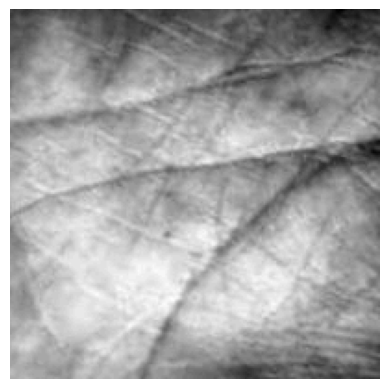

In [4]:
test = imread('roi_test.jpg')
plt.imshow(test, cmap='gray')
plt.axis('off')

print(f"Image have shape (rows, column) = {test.shape}")
print(test.dtype)
plt.show()

## Data storing object for training and testing dataset: Plam_Graph
Chưa được sử dụng trong đoạn code vì mới chỉ test với 1 hình ảnh

In [5]:

class Palm_Graph():
    def __init__(self, train, test):
        assert (np.array(train).shape == np.array(test).shape)
        self.train = train
        self.test = test
        self.rows, self.cols = train[0].shape

# chỉnh lại path cho phù hợp!!
# ở đây chỉ dùng 1 hình ảnh để test feature extraction
train_data_path =''
test_data_path = ''

def get_data(number):
    number = str(number)
    train_files = sorted(glob.glob(os.path.join(train_data_path, number.zfill(3) + '*.bmp')))
    test_files = sorted(glob.glob(os.path.join(test_data_path, number.zfill(3) + '*.bmp')))
    train_data = [imread(graph) for graph in train_files]
    test_data = [imread(graph) for graph in test_files]
    palm = Palm_Graph(train_data, test_data)
    return palm


## Generate gabor filter

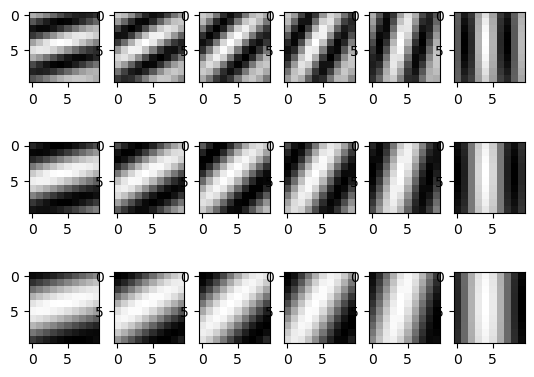

In [6]:
class Gabor():
    def __init__(self, R, C, n_orientation, scale):
        self.R = R
        self.C = C
        self.n_orientation = n_orientation
        self.scale = scale
        self.orientation = np.array([ u * np.pi / n_orientation for u in range (1, n_orientation + 1)])
        self.gabor_filters_sets = [gabor_wavelet(R, C, u, scale, n_orientation) for u in range(1, n_orientation + 1)]

    # filter image through gabor filter
    def filtering(self, img):
        graphs = np.array([cv2.filter2D(img, -1, np.real(gw)) for gw in self.gabor_filters_sets])
        return graphs

    def plot_filters(self, n_scale):
        gabor_filters = []
        fig = plt.figure()
        for v in range (1, n_scale + 1):
            for u in range(1, self.n_orientation + 1):
                gw = gabor_wavelet(self.R, self.C, u, v , self.n_orientation)
                fig.add_subplot(n_scale, self.n_orientation, self.n_orientation * (v- 1) + u)
                plt.imshow(np.real(gw), cmap='gray')
        plt.show()



def gabor_wavelet(rows, cols, orientation, scale, n_orientation):
    kmax = np.pi / 2        # 1.5707963267948966
    f = np.sqrt(2)          # 1.4142135623730951
    delt2 = (2 * np.pi) ** 2
    k = (kmax / (f ** scale)) * np.exp(1j * orientation * np.pi / n_orientation / 2)
    kn2 = np.abs(k) ** 2
    gw = np.zeros((rows, cols), np.complex128)

    for m in range(int(-rows / 2) + 1, int(rows / 2) + 1):
        for n in range(int(-cols / 2) + 1, int(cols / 2) + 1):
            t1 = np.exp(-0.5 * kn2 * (m ** 2 + n ** 2) / delt2)
            t2 = np.exp(1j * (np.real(k) * m + np.imag(k) * n))
            t3 = np.exp(-0.5 * delt2)
            gw[int(m + rows / 2 - 1), int(n + cols / 2 - 1)] = (kn2 / delt2) * t1 * (t2 - t3)

    return gw


n_orientation = 6
scale = 2
GA = Gabor(10, 10, n_orientation, scale)
gabor_filters = GA.gabor_filters_sets
GA.plot_filters(3)


## Laplacian Filter

In [8]:
def Lo_pass_Gaussian_procwess(img, D0):
    rows, cols = img.shape
    mask = np.zeros((rows, cols))
    Locx = np.array(list(range(cols)) * rows).reshape([rows, cols])
    Locy = np.transpose((np.array(list(range(rows)) * cols).reshape([cols,rows])))
    D = np.sqrt((Locx - cols / 2) ** 2 + (Locy - rows / 2 ) ** 2)
    mask = np.exp(-D ** 2 / D0 ** 2 / 2)

    f1 = np.fft.fft2(img)
    f1shift = np.fft.fftshift(f1)
    f1shift = f1shift * mask
    f2shift = np.fft.ifftshift(f1shift)
    img_new = np.fft.ifft2(f2shift)
    img_new = np.abs(img_new)

    return img_new

def LOG_preprocess(img, R0 = 40 , ksize = 5):
    AfterGaussian = np.uint8(Lo_pass_Gaussian_procwess(img, R0))
    processed = cv2.Laplacian(AfterGaussian, -1, ksize=ksize)
    img = cv2.equalizeHist(img)             #????????????????????????????????
    return processed

### Code test


In [31]:
def refine_skeleton(skeleton_image, min_length=50):
    """
    Refine the skeleton image to remove noise and improve line connectivity.

    Args:
        skeleton_image (numpy.ndarray): Binary skeletonized image.
        min_length (int): Minimum length of connected components to retain.

    Returns:
        numpy.ndarray: Refined skeleton image.
    """
    # Remove small objects to eliminate noise
    refined_skeleton = remove_small_objects(skeleton_image > 0, min_size=min_length, connectivity=2)

    # Apply skeletonization again to ensure a clean, 1-pixel width skeleton
    refined_skeleton = skeletonize(refined_skeleton)

    return refined_skeleton.astype(np.uint8)

def extract_dominant_lines_contours(refined_skeleton, num_lines=3):
    """
    Extract the top N dominant lines from a refined skeleton image using connected component analysis.

    Args:
        refined_skeleton (numpy.ndarray): Refined skeletonized binary image.
        num_lines (int): Number of dominant lines to retain.

    Returns:
        numpy.ndarray: Image with only the dominant lines drawn.
    """
    # Label connected components in the skeletonized image
    labeled_image = label(refined_skeleton, connectivity=2)
    regions = regionprops(labeled_image)

    # Sort connected components by their length (bounding box size or major axis length)
    sorted_regions = sorted(regions, key=lambda r: r.major_axis_length, reverse=True)

    # Create a blank image to store the dominant lines
    dominant_lines_image = np.zeros_like(refined_skeleton, dtype=np.uint8)

    # Retain only the top `num_lines` longest components
    for region in sorted_regions[:num_lines]:
        for coords in region.coords:
            dominant_lines_image[coords[0], coords[1]] = 255

    return dominant_lines_image



def extract_dominant_lines(skeletonized_image, num_lines=3):
    """
    Extract the dominant lines from a skeletonized image using Hough Line Transform.

    Args:
        skeletonized_image (numpy.ndarray): Skeletonized binary image.
        num_lines (int): Number of dominant lines to retain.

    Returns:
        numpy.ndarray: Image with only the dominant lines drawn.
    """
    # Convert to uint8 for HoughLinesP
    binary_uint8 = (skeletonized_image > 0).astype(np.uint8) * 255

    # Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(binary_uint8, rho=1, theta=np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

    # Calculate lengths of each detected line
    if lines is not None:
        line_lengths = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            line_lengths.append((length, (x1, y1, x2, y2)))

        # Sort lines by length in descending order
        line_lengths = sorted(line_lengths, key=lambda x: x[0], reverse=True)

        # Select the top `num_lines` lines
        dominant_lines = line_lengths[:num_lines]

        # Create a blank image to draw the dominant lines
        output_image = np.zeros_like(skeletonized_image, dtype=np.uint8)
        for _, (x1, y1, x2, y2) in dominant_lines:
            cv2.line(output_image, (x1, y1), (x2, y2), 255, 1)

        return output_image
    else:
        print("No lines detected!")
        return np.zeros_like(skeletonized_image, dtype=np.uint8)


def skeletonize_image(binary_image):
    """
    Skeletonizes the input binary image.

    Args:
        binary_image (numpy.ndarray): Binary image where lines are highlighted (0 and 255 values).

    Returns:
        numpy.ndarray: Skeletonized image.
    """
    # Convert binary image to boolean for skeletonize function
    binary_boolean = binary_image > 0

    # Skeletonize the image
    skeleton = skeletonize(binary_boolean)

    # Convert skeleton back to uint8 for visualization or further processing
    skeletonized_image = img_as_ubyte(skeleton)

    return skeletonized_image


def merge_components(skeleton_image, iterations=2):
    """
    Merge nearby components in a skeleton image using dilation and re-skeletonization.

    Args:
        skeleton_image (numpy.ndarray): Skeletonized binary image.
        iterations (int): Number of iterations for dilation.

    Returns:
        numpy.ndarray: Skeletonized image after merging nearby components.
    """
    # Dilate the skeleton to close small gaps
    dilated = binary_dilation(skeleton_image > 0, iterations=iterations)

    # Re-skeletonize to restore a clean, thin structure
    merged_skeleton = skeletonize(dilated)

    return merged_skeleton.astype(np.uint8)


## Process the image to extract feature


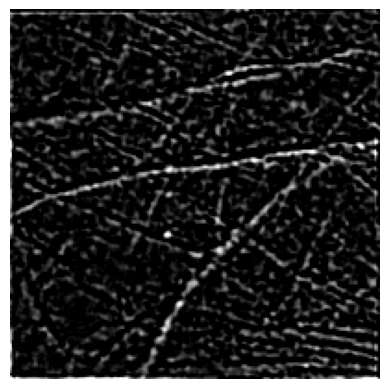

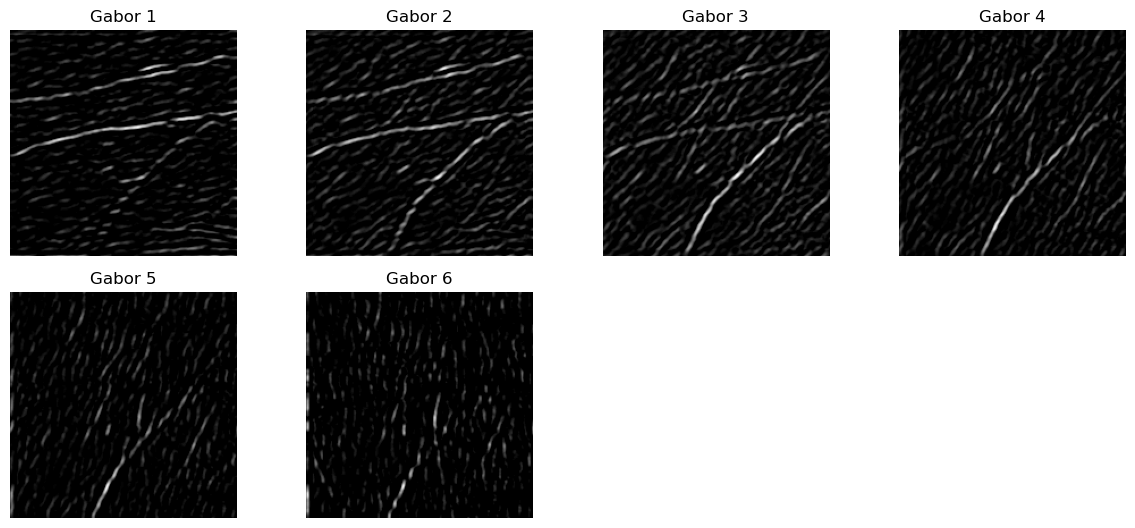

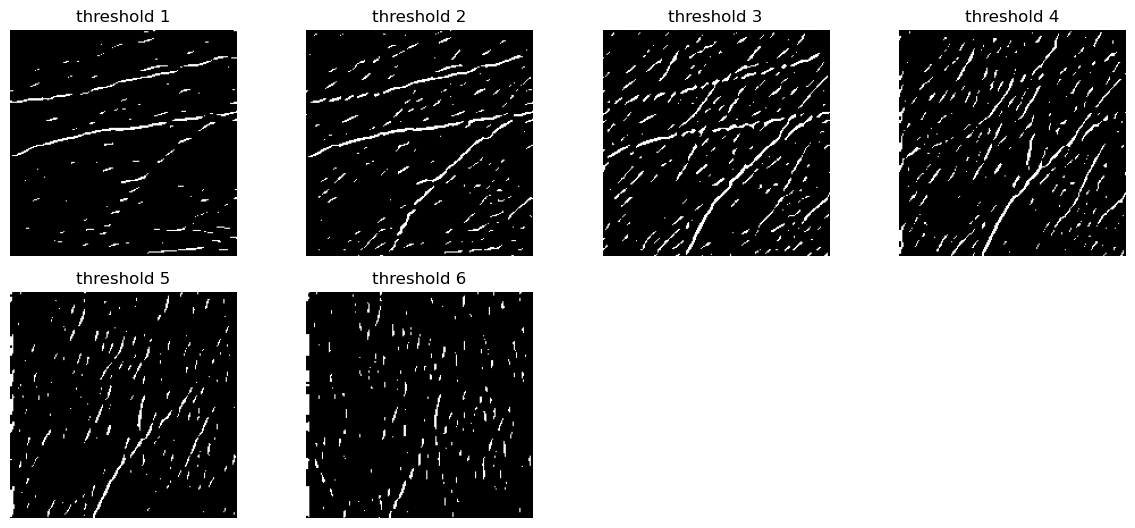

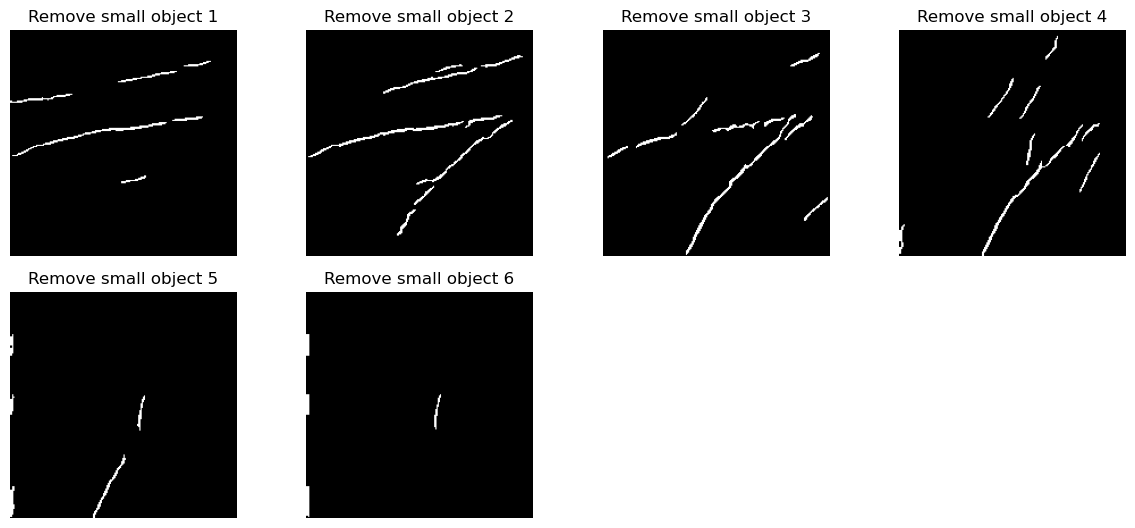

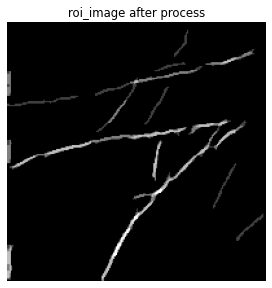

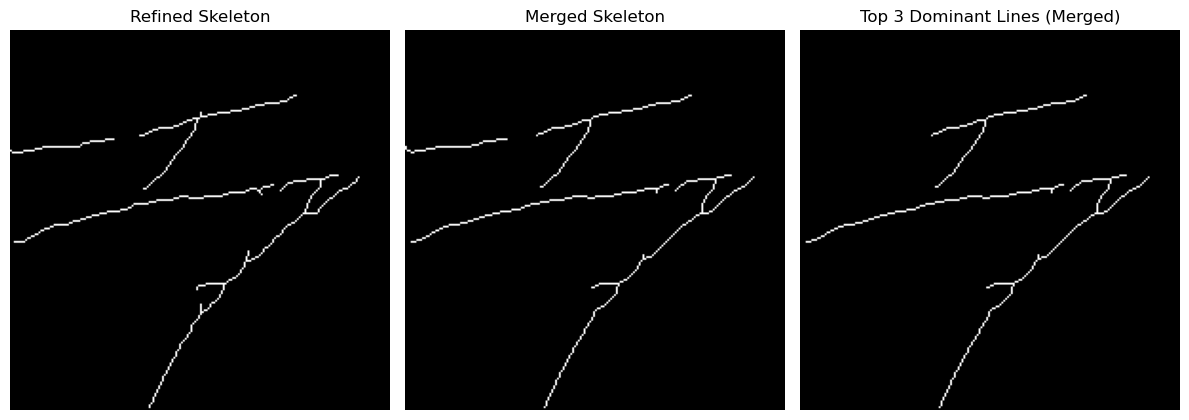

In [40]:
def show_array_img(arr, process):
    plt.figure(figsize=(12, 8))  # Đặt kích thước cửa sổ
    for idx, element in enumerate(arr):
        plt.subplot(3, 4, idx + 1)  # Sắp xếp ảnh trên lưới 3x4 (hoặc thay đổi tuỳ số lượng ảnh)
        plt.imshow(element, cmap='gray')  # Hiển thị ảnh ở dạng grayscale
        plt.title(f"{process} {idx+1}")  # Thêm tiêu đề cho từng ảnh
        plt.axis('off')  # Tắt trục toạ độ

    plt.tight_layout()  # Căn chỉnh lưới để không bị chồng lấn
    plt.show()

def process(img):

    # Laplacian process image with above function
    img = LOG_preprocess(img)

    # storing output after gabor filter
    After_gabor = []

    # Gabor process image with the first cell code above
    for i, gw in enumerate(gabor_filters):
        element =  cv2.filter2D(img, -1, np.real(gw))       # filter2d image với mỗi kernel là một gabor filter
        After_gabor.append(element)


    show_array_img(After_gabor, "Gabor")


    Two_value = []
    for i, line in enumerate(After_gabor):
        _, TW = cv2.threshold(line, 0 , 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        kernel = np.ones((2,2), np.uint8)
        TW = cv2.erode(TW, kernel)

        Two_value.append(TW)

    show_array_img(Two_value, "threshold")

    con = []


    for i in Two_value:
        conective = morphology.remove_small_objects(i > 0, min_size=40, connectivity=1)
        con.append(conective)

    line = (np.sum(con, axis = 0) / len(con))

    show_array_img(con, "Remove small object")


    return line



plt.imshow(LOG_preprocess(test), cmap='gray')
plt.axis('off')
plt.show()


res1 = process(test)




fig = plt.figure(dpi=70)
plt.imshow(res1, cmap='gray')
plt.axis('off')
plt.title('roi_image after process')
plt.show()

# begin test

# Assuming `res1` is the final processed image from your code
skeletonized_output = skeletonize_image(res1)

# Refine the skeletonized image to remove noise and small segments
refined_skeleton = refine_skeleton(skeletonized_output, min_length=40)

# Merge components in the refined skeleton to close gaps
merged_skeleton = merge_components(refined_skeleton, iterations=2)

# Extract the top 3 dominant lines from the merged skeleton
dominant_lines_merged = extract_dominant_lines_contours(merged_skeleton, num_lines=3)

# Visualize the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Refined Skeleton")
plt.imshow(refined_skeleton, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Merged Skeleton")
plt.imshow(merged_skeleton, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Top 3 Dominant Lines (Merged)")
plt.imshow(dominant_lines_merged, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

#end test


### Test convert to grid

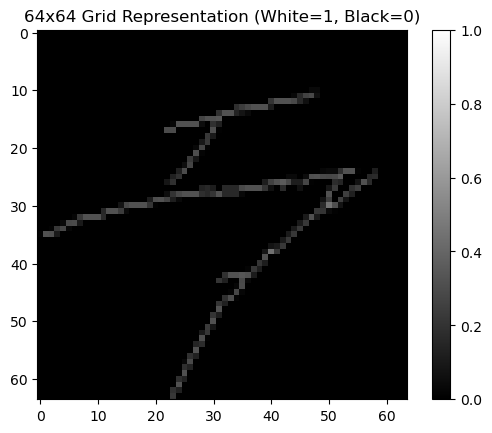

Grid Matrix (64x64):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [49]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def convert_to_grid(image, grid_size=(64, 64)):
    """
    Convert a binary line image into a feature matrix of average intensities for a grid,
    where white = 1 and black = 0.

    Args:
        image (numpy.ndarray): Input binary image (values between 0 and 255).
        grid_size (tuple): Size of the grid (rows, cols), default is (64, 64).

    Returns:
        numpy.ndarray: Feature matrix of size grid_size with normalized average intensities.
    """
    # Normalize the image: white = 1, black = 0
    normalized_image = (image > 0).astype(float)  # Convert to 0 (black) and 1 (white)

    # Resize the image to fit the grid size exactly
    resized_image = cv2.resize(normalized_image, grid_size, interpolation=cv2.INTER_AREA)

    return resized_image

# Assuming `dominant_lines_merged` is the final ndarray containing the 3 lines
grid_matrix = convert_to_grid(dominant_lines_merged, grid_size=(64, 64))

# Save the grid matrix for further use
# np.save("line_features_64x64.npy", grid_matrix)  # Save as a .npy file
np.savetxt("line_features_64x64.csv", grid_matrix, delimiter=",")  # Save as a .csv file

# Visualize the grid matrix as an image
plt.imshow(grid_matrix, cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.title("64x64 Grid Representation (White=1, Black=0)")
plt.show()

# Print the resulting matrix
print("Grid Matrix (64x64):\n", grid_matrix)
